In [33]:
import pickle, tqdm, time, os, numpy as np, pandas as pd
from pymongo import MongoClient
from pprint import pprint
pd.set_option('max_colwidth', 100)
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [2]:
def getMongoUri(auth_filename='../auths/mongo_uri.pkl'):
    with open(auth_filename, 'rb') as file:
        pwd = pickle.load(file)
    return pwd['mongo_uri']

def createMongoClient(db='aita'):
    mongo_uri = getMongoUri()
    client = MongoClient(mongo_uri)
    db = client.aita
    return client, db

In [3]:
def moveVector(sourceVector, destinationVector, direction, magnitude = None):
    magnitude = magnitude if magnitude is not None else 0.5
    new_q = sourceVector + direction*magnitude*(destinationVector - sourceVector)
    new_q = new_q / np.linalg.norm(new_q)
    return new_q

In [4]:
client, db = createMongoClient()
start = time.time()
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
model(['testing caching'])
end = time.time()
delta = (end-start)
print("It took {} seconds to load and cache the model into memory".format(delta))

It took 6.354276895523071 seconds to load and cache the model into memory


In [5]:
userInput = "password"
textSearchQuery = {"$text": {"$search": userInput}}

In [6]:
projection = {"selftextVector":1, 'selftext':1, 'title':1}
count = db.clean.posts.v2.count_documents(textSearchQuery)
cursor = db.clean.posts.v2.find(textSearchQuery, projection = projection)
print("Total documents found: {}".format(count))

Total documents found: 2303


In [7]:
'''
Method 1: 
- Calculate average vector of all returned docs vectors
- Use the avg vector as the init vector
'''
avgVector = None
for c in tqdm.tqdm_notebook(cursor, total=count):
    currTextVector = np.array(c['selftextVector'])
    if avgVector is None:
        avgVector = currTextVector
    else:
        avgVector += currTextVector
avgVector /= count
avgVector = avgVector / np.linalg.norm(avgVector)

/Users/alamjeetsingh/opt/anaconda3/envs/cs448/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/2303 [00:00<?, ?it/s]

In [8]:
'''
Method 2:
- Convert user query input into its own vector
- Use that as init vector
'''

passwordVector = model([userInput]).numpy()[0]

Assume the user says they want to find similar docs to the post below

In [15]:
cursor = db.clean.posts.v2.find(textSearchQuery, projection = projection, limit=1)
feedbackPost = list(cursor)[0]

In [16]:
feedbackPost['selftext']

"I (27f) have 3 siblings (28m, 34f, 38m). My parents have used the same crappy password for the last 20years. Example, Password123. (It's worse then that)   \n\nMy brothers and I share a Netflix service with my parents. I've honestly never thought to much about it. Anyway, my parents Nexflix account was stolen, presumably because of their crappy password. They were able to get the account fixed, and their new password is Password4321(Not actual password, duh). Half joking them their password is still weak sauce. My sister goes into this huge rant how I'm not the one to pay for Netflix, and I have no say over their Netflix password. It ends with me basically telling her that I rarely use their Netflix, and I didn't want their account fucked up again. She replied with an eyeroll emoji 🙄. AITA for telling my parents their password sucks?"

In [17]:
feedbackPost['title']

'For telling my parents their password sucks..'

In [18]:
# move towards the feedback doc

In [19]:
avgVector = moveVector(avgVector, np.array(feedbackPost['selftextVector']), 1)

In [20]:
passwordVector = moveVector(passwordVector, np.array(feedbackPost['selftextVector']), 1)

Comparing the Top Most Similar Documents found in full corpus by using avgVector vs password Vector

In [21]:
projection = {"selftextVector":1, "id":1, "title":1, "selftext":1}
count = db.clean.posts.v2.count_documents({})
cursor = db.clean.posts.v2.find({}, projection = projection)
avgVecResults = []
passwordVecResults = []
for c in tqdm.tqdm_notebook(cursor, total=count):
    currTextVector = np.array(c['selftextVector'])
    avgVecScore = avgVector.dot(currTextVector)
    passwordVecScore = passwordVector.dot(currTextVector)
    
    avgVecResults.append((avgVecScore, c['id'], c['title'], c['selftext']))
    passwordVecResults.append((passwordVecScore, c['id'], c['title'], c['selftext']))

/Users/alamjeetsingh/opt/anaconda3/envs/cs448/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/490330 [00:00<?, ?it/s]

In [22]:
avgVecSorted = sorted(avgVecResults, key=lambda x:x[0], reverse=True)
passwordVecSorted = sorted(passwordVecResults, key=lambda x:x[0], reverse=True)

In [23]:
avgdf = pd.DataFrame(avgVecSorted, columns=['Similarity Score', 'ID', 'Title', 'Text'])
pwddf = pd.DataFrame(passwordVecSorted, columns=['Similarity Score', 'ID', 'Title', 'Text'])

In [24]:
avgdf.head(10) # average method

,Similarity Score,ID,Title,Text
0,0.915580,ex19jl,AITA For tell my parents their password is weaksauce..,"I (27f) have 3 siblings (28m, 34f, 38m). My parents have used the same crappy password for the l..."
1,0.909472,ex0ut5,For telling my parents their password sucks..,"I (27f) have 3 siblings (28m, 34f, 38m). My parents have used the same crappy password for the l..."
2,0.830794,fzuf7q,AITA for blocking my sister's access to Netflix,A bit of context. In my house I pay for Netflix and my younger sister chips in for the second sc...
3,0.818386,hbqteu,AITA for adding my sister to a shared Netflix account without consulting my gf?,So my family is going through a hard time. My mother has advanced Alzheimer’s and my sister is u...
4,0.817205,c7u0xe,AITA for changing my password so my sister doesn't have access to my account?,About a year ago my sister and I had a very large falling out. It basically ended with my sister...
5,0.816461,d4nabx,AITA For being pissed at my girlfriend for giving my Netflix email and password to her family wi...,"(Financially speaking, it’s not really that big a deal for me since I have to pay the same amoun..."
6,0.813844,dl57zx,"AITA for denying my brother's ex in the Dominican Republic, who I never met, access to the Netfl...",I (32/F) have two younger brothers (30 and 26) and since I have a stable career and more disposa...
7,0.808525,ia4w5v,AITA for changing the Netflix password on my Boyfriend's Mom?,TL;DR Boyfriend’s Mom was hogging my Netflix account that I share with my family. After I asked ...
8,0.801051,iabzh3,AITA for kicking my siblings off of my Netflix and Disney+?,A few months ago my siblings stopped talking to me for no apparent reason- there was no argument...
9,0.800498,ic8hpd,WIBTA if I kicked my girlfriend off my Hulu and Disney+ accounts?,"First post, please deal with formating. Also sorry if this is obvious, but I have anxiety and ne..."


In [25]:
pwddf.head(10) # user input method

,Similarity Score,ID,Title,Text
0,0.822199,ex0ut5,For telling my parents their password sucks..,"I (27f) have 3 siblings (28m, 34f, 38m). My parents have used the same crappy password for the l..."
1,0.799815,ex19jl,AITA For tell my parents their password is weaksauce..,"I (27f) have 3 siblings (28m, 34f, 38m). My parents have used the same crappy password for the l..."
2,0.650136,e5sgwo,AITA for getting pissed that my fiancé gave our personal password out to a stranger?,"For context the password was to our DirectTV account to one of his coworkers that I do not know,..."
3,0.646860,8aamwf,AITA: For changing the Netflix password,So for the longest time I have been sharing my Netflix account with my family. It’s my two cousi...
4,0.614610,78itcz,[WIBTA] Would I be the asshole if I cut my Dad off of Netflix?,"About four of five years ago, my father retired to another state and was trying to cut back on b..."
5,0.614434,catqdl,AITA for calling out a family member for saying my former password outloud?,I used to play video games with my brother/cousin and would share accounts long time ago. \n\nJu...
6,0.607890,iabzh3,AITA for kicking my siblings off of my Netflix and Disney+?,A few months ago my siblings stopped talking to me for no apparent reason- there was no argument...
7,0.606722,dbn4lt,AITA changing the Netflix password?,https://m.imgur.com/gallery/QjWKfmD\n\nI had to change the Netflix password because no one knew ...
8,0.600590,cksvnm,AITA for not wanting to give my password to my mom?,"To start off, it probably noteworthy that I am 18 years old. This would obviously be a different..."
9,0.594947,ebwr1x,AITA because I refuse to give my in-laws the passwords to my streaming media accounts?,Apparently I’m an asshole because I refuse to give my Netflix and other streaming media password...


In [26]:
ndf = pd.DataFrame()
ndf['Avg_method_score'] = avgdf['Similarity Score']
ndf['UserInput_method_score'] = pwddf['Similarity Score']
ndf['rank'] = [x for x in range(1, len(avgdf) + 1)]

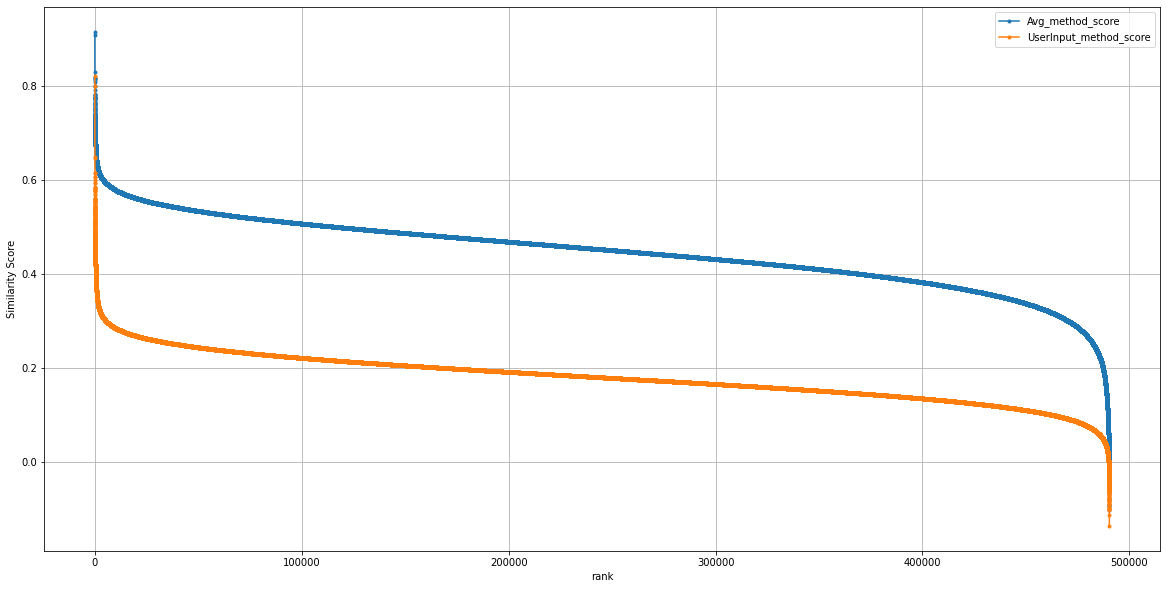

In [47]:
ndf.set_index('rank').plot(figsize=(20,10), style='.-', ylabel='Similarity Score', grid=True);

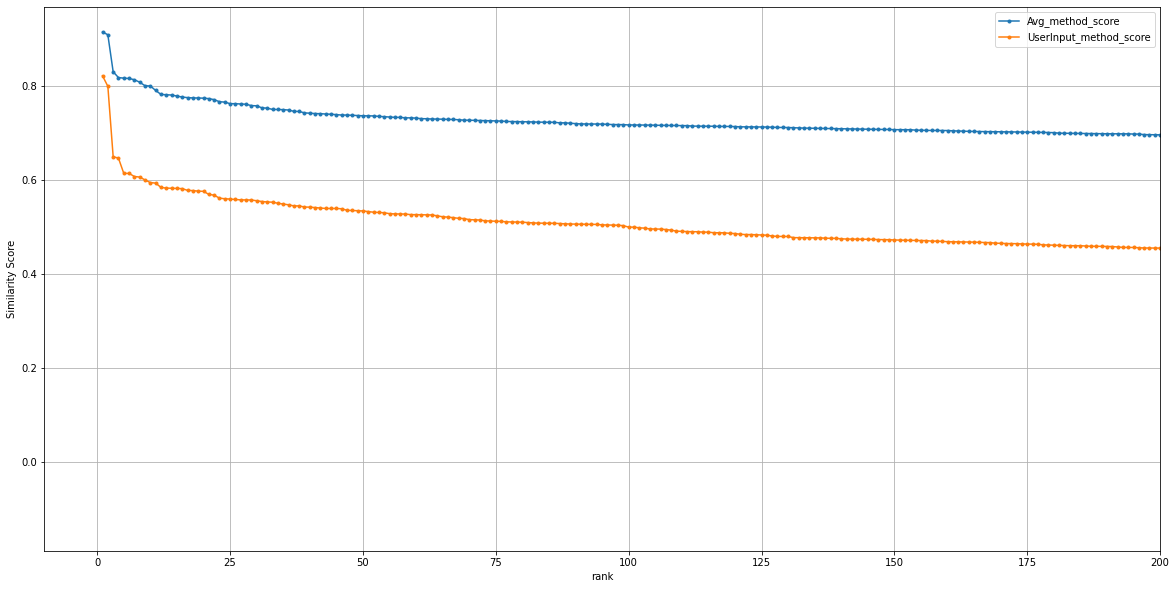

In [48]:
ndf.set_index('rank').plot(figsize=(20,10), style='.-', ylabel='Similarity Score', grid=True, xlim=(-10,200));